In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Find and read data
from glob import glob
products = ('2B-CWC-RVOD', 'ECMWF-AUX')
versions = ('P1_R05', 'P_R05')
data_root = '/global/cfs/cdirs/e3sm/bhillma/obs_datasets/cloudsat'
files = {c: sorted(glob(f'{data_root}/{c}/*/*.hdf')) for c in products}

debug = True

In [3]:
# Define some functions to work with CloudSat HDF data. These were pulled
# from my misreval git repo. Should maintain these separately!

# Some common imports
import pandas, datetime, calendar, os, psutil

# function to digest SDs and VDATA from HDF files and return xarray datasets
# attempts to be smart about missing data and attributes and such
# but HDF is an abomination, and seems to be difficult to get
# information about coordinate variables and such, especially for
# things like CloudSat data, where some data is stored in VDATA and
# other data stored in SDs. This probably needs some work...
from pyhdf.SD import SD, SDC
from pyhdf.HDF import HDF
import pyhdf.VS
def open_dataset_hdf(filename, variables=None, drop_variables=[]):
    da_dict = {}
    
    # First read SD (scientific datasets)
    sd = SD(filename)
    if variables is None: 
        data_vars = sd.datasets().keys()
    else:
        data_vars = variables
    for dname in data_vars:
        
        if dname in drop_variables: continue
        if dname not in sd.datasets().keys(): continue
        
        sds = sd.select(dname)

        # get (masked) data
        d = np.where(sds[:] != sds.getfillvalue(), sds[:], np.nan)

        # check for more masks
        if 'missing' in sds.attributes():
            d[d == sds.missing] = np.nan

        # unpack data
        if 'offset' in sds.attributes() and 'factor' in sds.attributes():
            d = d / sds.factor + sds.offset

        # coordinate variables...how to do this?! Look for VDATA?
        # just save as DataArray for now, without coordinate variables...
        dims = [sds.dim(i).info()[0] for i in range(len(sds.dimensions()))]

        da_dict[dname] = xr.DataArray(d, dims=dims, attrs=sds.attributes(), name=dname)

        # Close this dataset
        sds.endaccess()

    # Close file
    sd.end()
    
    # ...now read VDATA...
    hdf = HDF(filename)
    vs = hdf.vstart()
    if variables is None: 
        data_vars, *__ = zip(*vs.vdatainfo())
    else:
        data_vars = variables
    for vname in data_vars:
        
        if vname in drop_variables: continue
        if vname not in [v[0] for v in vs.vdatainfo()]: continue
            
        # attach vdata
        vd = vs.attach(vname)

        # get vdata info
        nrec, mode, fields, *__ = vd.inquire()
        if nrec == 0:
            vd.detach()
            continue

        # read data
        d = np.array(vd[:]).squeeze()

        # make sure not to overwrite coordinate variables
        if all([vname not in da.dims for v, da in da_dict.items()]):
            da_dict[vname] = xr.DataArray(d)

        vd.detach()

    # clean up
    vs.end()

    # HDF files do not always close cleanly, so close manually
    hdf.close()
    
    return xr.Dataset(da_dict)
    
        
def get_geoprof_time(ds, return_datetime=False):
    """
    Read time stamp and return seconds since Epoch
    """

    # read data
    profile_sec = ds['Profile_time']
    start_tai = ds['TAI_start']

    # TAI time for each profile
    time_tai = (profile_sec + start_tai)  # seconds since 00:00:00 Jan 1

    # get epoch for TAI start of 00:00:00 Jan 1
    tai_base = calendar.timegm((1993, 1, 1, 0, 0, 0))

    # get epoch time as a datetime
    epoch = time_tai + tai_base
    
    # get array of datetime objects
    dt = np.array([datetime.datetime.utcfromtimestamp(t) for t in epoch.values])
    
    # return xarray DataArray
    if return_datetime:
        return dt
    else:
        return xr.DataArray(dt, dims=profile_sec.dims, coords=profile_sec.coords, name='time')



In [4]:
ds = open_dataset_hdf(files[products[0]][0], drop_variables=('EC_height'))

In [5]:
print(ds)

<xarray.Dataset>
Dimensions:                          (Nbin:2B-CWC-RVOD: 125, Nray:2B-CWC-RVOD: 37081, dim_0: 37081)
Dimensions without coordinates: Nbin:2B-CWC-RVOD, Nray:2B-CWC-RVOD, dim_0
Data variables:
    Height                           (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float64 ...
    Liq_Water_Content                (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Liq_Water_Content_Uncert         (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Cloud_Liq_Water_Content          (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Precip_Liq_Water_Content         (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Liq_Geom_Mean_Radius             (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Liq_Geom_Mean_Radius_Uncert      (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Liq_Number_Concentration         (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Liq_Number_Concentration_Uncert  (Nray:2B-CWC-RVOD, Nbin:2B-CWC-RVOD) float32 ...
    Ice_Water_Conte

In [6]:
zb = np.arange(0, 26000, 500)
zb.shape, zb

((52,),
 array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
         4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
         9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
        13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500,
        18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000,
        22500, 23000, 23500, 24000, 24500, 25000, 25500]))

In [7]:
#xb = np.concatenate([grid_ds.lon_bnds[:,0], [grid_ds.lon_bnds[-1,-1]]])
#yb = np.concatenate([grid_ds.lat_bnds[:,0], [grid_ds.lat_bnds[-1,-1]]])
# Fix bounds to go from -180 to 180 instead of 0 to 360
#xb = np.where(xb <= 180, xb, xb - 360)
xb = np.linspace(-180, 180, 361)
yb = np.linspace(-90, 90, 181)
xb.min(),xb.max()

(-180.0, 180.0)

In [8]:
# Aggregate onto regular grid; compute sums and counts, and then return a mean if counts is large enough
import numba as nb
# This function is compact and flexible, but cannot be accelerated with numba, so wrap below
#@nb.jit(nopython=True)
def gridded_sum(d, coords, bounds): #x, y, z, xb, yb, zb):
        
    # Compute grid centers, since we are passing grid bounds
    centers = [(b[:-1] + b[1:]) / 2.0 for b in bounds]
    
    # Initialize sums and counts
    new_shape = [len(b) - 1 for b in bounds]
    dsum = np.zeros(new_shape)
    dcnt = np.zeros(new_shape)
    
    # Loop over points, aggregate appropriate sums
    for idx in range(len(d)):
        
        if np.isfinite(d[idx]):
            # Find nearest point on grid
            index = tuple([np.argmin((x[idx] - xc)**2.0) for x, xc in zip(coords, centers)])# ix,iy,iz])
            dsum[index] = dsum[index] + d[idx]
            dcnt[index] = dcnt[index] + 1
    
    return dsum, dcnt

def gridded_sum_nn(d, coords, centers):
    if len(coords) == 2:
        return gridded_sum2d(d, *coords, *centers)
    elif len(coords) == 3:
        return gridded_sum3d(d, *coords, *centers)

@nb.jit(nopython=True)
def gridded_sum2d(d, x, y, xc, yc):
      
    # Initialize sums and counts
    new_shape = (len(xc), len(yc))
    dsum = np.zeros(new_shape)
    dcnt = np.zeros(new_shape)
    
    # Loop over points, aggregate appropriate sums
    for idx in range(len(d)):
        
        if np.isfinite(d[idx]):
            # Find nearest point on grid
            ix, iy = [np.argmin((coord[idx] - center)**2.0) for coord, center in zip((x, y), (xc, yc))]
            dsum[ix,iy] = dsum[ix,iy] + d[idx]
            dcnt[ix,iy] = dcnt[ix,iy] + 1
    
    return dsum, dcnt

@nb.jit(nopython=True)
def gridded_sum3d(d, x, y, z, xc, yc, zc):
    
    # Initialize sums and counts
    new_shape = (len(xc), len(yc), len(zc))
    dsum = np.zeros(new_shape)
    dcnt = np.zeros(new_shape)
    
    # Loop over points, aggregate appropriate sums
    for idx in range(len(d)):
        
        if np.isfinite(d[idx]) and d[idx] >= 0:
            # Find nearest point on grid
            ix, iy, iz = [np.argmin((coord[idx] - center)**2.0) for coord, center in zip((x, y, z), (xc, yc, zc))]
            dsum[ix,iy,iz] = dsum[ix,iy,iz] + d[idx]
            dcnt[ix,iy,iz] = dcnt[ix,iy,iz] + 1
    
    return dsum, dcnt

In [9]:
# Compute grid centers
xgrd = (xb[:-1] + xb[1:]) / 2.0
ygrd = (yb[:-1] + yb[1:]) / 2.0
zgrd = (zb[:-1] + zb[1:]) / 2.0

In [10]:
# A test variable from the dataset
v = 'Ice_Water_Content'

# Broadcast lat and lon coords to full height grid, since height may differ from location
# to location, and we want to produce a gridded dataset we can later create climatologies from
x = np.broadcast_to(ds.Longitude.values, ds.Height.T.shape).T
y = np.broadcast_to(ds.Latitude.values, ds.Height.T.shape).T

# Grid the data, summing data values and counts
d_sum, d_cnt = gridded_sum_nn(ds[v].values.flatten(), [x.flatten(), y.flatten(), ds.Height.values.flatten()], [xgrd, ygrd, zgrd])

<ipython-input-11-915e1da7893a>:2: RuntimeWarning: invalid value encountered in true_divide
  d_sum_test = np.ma.masked_where(d_cnt == 0, d_sum/d_cnt)
<ipython-input-11-915e1da7893a>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl = ax.pcolormesh(xgrd, ygrd, d_sum_test[:,:,:].sum(axis=-1).T)


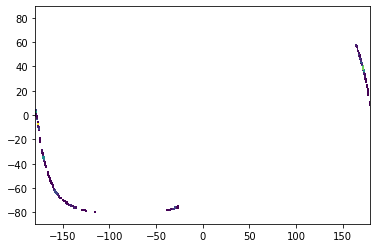

In [11]:
fig, ax = plt.subplots(1, 1)
d_sum_test = np.ma.masked_where(d_cnt == 0, d_sum/d_cnt)
pl = ax.pcolormesh(xgrd, ygrd, d_sum_test[:,:,:].sum(axis=-1).T)
#pl = ax.scatter(ds.Longitude, ds.Latitude, c=data.sum(axis=-1))
#ax.set_xlim(0, 50)
#ax.set_ylim(-40, -20)

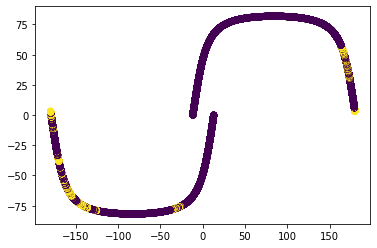

In [12]:
fig, ax = plt.subplots(1, 1)
pl = ax.scatter(ds.Longitude, ds.Latitude, c=(ds[v].sum(axis=-1)>0), )

In [13]:
pgrd = np.array([ 200.,  300.,  400.,  500.,  600.,  700.,  800.,  850.,  925., 1000.], dtype=np.float64)

In [14]:
def to_netcdf_file(outputfile, coords_in, monthly_sums, monthly_cnts, attrs):
    months, xgrd, ygrd, zgrd = coords_in
    
    # Save counts (and means) to a netcdf file
    coords = {
        'month': xr.DataArray(months, dims=('month'), name='month'),
        'lon': xr.DataArray(xgrd, dims=('lon'), name='lon', attrs={'long_name': 'Longitude', 'units': 'degrees east'}),
        'lat': xr.DataArray(ygrd, dims=('lat'), name='lat', attrs={'long_name': 'Latitude', 'units': 'degrees north'}),
        #'height': xr.DataArray(zgrd, dims=('height'), name='height', attrs={'long_name': 'Height', 'units': 'm'}),
        'plev': xr.DataArray(zgrd, dims=('plev'), name='plev', attrs={'long_name': 'Pressure', 'units': 'hPa'})
    }
    data_arrays = {}
    for v in monthly_sums.keys():
        if len(monthly_sums[v].shape) == 3:
            dims = ('month', 'lon', 'lat')
        elif len(monthly_sums[v].shape) == 4:
            dims = ('month', 'lon', 'lat', 'plev')
        else:
            raise RuntimeError('Bad dims')
        # Save raw sums data
        data_arrays[v + '_sums'] = xr.DataArray(
            monthly_sums[v], name=v+'_sums', dims=dims, coords={c: coords[c] for c in dims},
            attrs={'long_name': f'{v} sum'},
        )
        # Save valid counts for each lat-lon-height bin
        data_arrays[v + '_counts'] = xr.DataArray(
            monthly_cnts[v], name=v+'_counts', dims=dims, coords={c: coords[c] for c in dims},
            attrs={'long_name': f'{v} valid counts'},
        )

    # Merge DataArrays into a Dataset and write to file
    ds_out = xr.Dataset(data_arrays)
    ds_out.to_netcdf(outputfile)
    ds_out.close()

In [15]:
# Get list of files for which we have both CS and aux data
cld_files = []
aux_files = []
missing_files = []
for f in files[products[0]]:
    f_aux = f.replace(products[0], products[1]).replace(versions[0], versions[1])
    if os.path.exists(f_aux):
        cld_files.append(f)
        aux_files.append(f_aux)
    else:
        missing_files.append(f)


In [18]:
print(len(files[products[0]]), len(cld_files), len(aux_files))
print(cld_files[-1], aux_files[-1])

35741 35740 35740
/global/cfs/cdirs/e3sm/bhillma/obs_datasets/cloudsat/2B-CWC-RVOD/2017/2017339141057_61739_CS_2B-CWC-RVOD_GRANULE_P1_R05_E06_F00.hdf /global/cfs/cdirs/e3sm/bhillma/obs_datasets/cloudsat/ECMWF-AUX/2017/2017339141057_61739_CS_ECMWF-AUX_GRANULE_P_R05_E06_F00.hdf


In [38]:
def process_files(cld_files, aux_files, data_vars, xgrd, ygrd, pgrd):
    
    bad_files = []
    processed_files = []
    
    # Shapes
    nx = len(xgrd)
    ny = len(ygrd)
    nz = len(pgrd)
    shape2d = (nx, ny)
    shape3d = (nx, ny, nz)
    
    # Initialize counts
    monthly_sums = {v: np.zeros([12, *shape3d]) for v in data_vars}
    monthly_cnts = {v: np.zeros([12, *shape3d]) for v in data_vars}
    
    # Loop over all files and aggregate sums and counts for each month
    for ifile, (f, f_aux) in enumerate(zip(cld_files, aux_files)):
        update_progress(ifile, len(cld_files))

        # If continuing where we left off, maybe already proccessed this one
        if f in processed_files: continue

        # Load data
        ds = open_dataset_hdf(f, variables=(*data_vars, 'Latitude', 'Longitude', 'Height', 'Profile_time', 'TAI_start'))

        # Load aux data
        ds_aux = open_dataset_hdf(f_aux, variables=('Pressure', 'Latitude', 'Longitude'), drop_variables=('EC_height'))
        p = ds_aux.Pressure.values.astype(np.float64) / 100.

        # Broadcast lat and lon coords to full height grid, since height may differ from location
        # to location, and we want to produce a gridded dataset we can later create climatologies from
        x = np.broadcast_to(ds.Longitude.values, p.T.shape).T
        y = np.broadcast_to(ds.Latitude.values, p.T.shape).T

        # Get month orbit falls into
        t = get_geoprof_time(ds)
        imonth = t.to_pandas()[0].month - 1

        # Grid the data, summing data values and counts
        for v in data_vars:
            if len(ds[v].shape) == 1:
                coords = [x.flatten(), y.flatten()]
                centers = [xgrd, ygrd]
            elif len(ds[v].shape) == 2:
                coords = [x.flatten(), y.flatten(), p.flatten()]
                centers = [xgrd, ygrd, pgrd]
            else:
                raise RuntimeError("Bad number of dimensions")

            sums, cnts = gridded_sum_nn(
                ds[v].values.flatten(), coords, centers
            )

            # Make sure we do not sum nans
            monthly_sums[v][imonth,...] = monthly_sums[v][imonth,...] + np.where(cnts > 0, sums, 0)
            monthly_cnts[v][imonth,...] = monthly_cnts[v][imonth,...] + np.where(cnts > 0, cnts, 0)

        ds.close()
        ds_aux.close()

        # Append to list of processed files
        processed_files.append(f)

        # Save to intermediate file
        with open(tmpfile_name, 'wb') as tmpfile:
            pickle.Pickler(tmpfile).dump([processed_files, bad_files, monthly_sums, monthly_cnts])

        # Update progress bar
        update_progress(ifile+1, len(cld_files))
        
    return monthly_sums, monthly_cnts, processed_files, bad_files

In [ ]:
from e3smplot.utils import update_progress
import os.path
import pickle

output_root = '/global/cfs/cdirs/e3sm/bhillma/obs_datasets/cloudsat'

# Initialize counts for each month
data_vars = [
    'Cloud_Liq_Water_Content', 
    'Ice_Water_Content', 
    'Liq_Water_Content', 
]
years = range(2007, 2020)
months = range(1, 13)

for year in years:
    
    # Find files for this year
    files = glob(f'{output_root}/{products[0]}/{year}/*.hdf')
    
    # Get list of files for which we have both CS and aux data
    cld_files = []
    aux_files = []
    missing_files = []
    for f in files:
        f_aux = f.replace(products[0], products[1]).replace(versions[0], versions[1])
        if os.path.exists(f_aux):
            cld_files.append(f)
            aux_files.append(f_aux)
        else:
            missing_files.append(f)

    # Process files for this year
    monthly_sums, monthly_cnts = process_files(cld_files, aux_files, data_vars, xgrd, ygrd, pgrd)
    
    # Save to netCDF file
    f_out = f'{output_root}/{products[0]}_{year}_monthly_counts.nc'
    to_netcdf_file(f_out, [months, xgrd, ygrd, pgrd], monthly_sums, monthly_cnts, ds[v].attrs)

Percent: [####------] 1912 of 4797 (39.86%)

In [24]:
processed_files[-1]

'/global/cfs/cdirs/e3sm/bhillma/obs_datasets/cloudsat/2B-CWC-RVOD/2017/2017338200314_61728_CS_2B-CWC-RVOD_GRANULE_P1_R05_E06_F00.hdf'

In [30]:
cld_files = []
aux_files = []
missing_files = []
for f in files[products[0]]:
    f_aux = f.replace(products[0], products[1]).replace(versions[0], versions[1])
    if os.path.exists(f_aux):
        cld_files.append(f)
        aux_files.append(f_aux)
    else:
        missing_files.append(f)

In [31]:
len(cld_files), len(aux_files), len(missing_files)

(5332, 5332, 30409)

In [29]:
len(cld_files), len(aux_files), len(missing_files)

(5209, 5209, 30532)

In [26]:
v = 'Cloud_Liq_Water_Content'
da = xr.DataArray(monthly_sums[v], name=v)
ds1 = xr.Dataset({v: da})
ds1.to_netcdf('test.nc')
ds1.close()

In [27]:
ds1 = xr.open_dataset('test.nc')
print(ds1)

<xarray.Dataset>
Dimensions:                  (dim_0: 12, dim_1: 360, dim_2: 180, dim_3: 10)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    Cloud_Liq_Water_Content  (dim_0, dim_1, dim_2, dim_3) float64 ...


In [29]:
ds1 = xr.open_dataset('test.nc')
print(ds1)
da1 = ds1[v]
ds_counts = xr.open_dataset(f_out)

d_sum = ds_counts[v+'_sums']
for ilev in range(len(d_sum.plev)):
    print(np.nanmax(da1[...,ilev]), np.nanmax(d_sum[...,ilev].values))

<xarray.Dataset>
Dimensions:                  (dim_0: 12, dim_1: 360, dim_2: 180, dim_3: 10)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    Cloud_Liq_Water_Content  (dim_0, dim_1, dim_2, dim_3) float64 ...
0.0 0.0
0.0010985081702724203 0.0010985081702724203
0.008338624800884986 0.008338624800884986
0.02622724637610563 0.02622724637610563
0.02704373256467818 0.02704373256467818
0.03740620635039704 0.03740620635039704
0.043407814384408994 0.043407814384408994
0.052140367864922155 0.052140367864922155
0.051808323729561304 0.051808323729561304
0.001300254601138029 0.001300254601138029


In [30]:
vnames = (
    'Cloud_Liq_Water_Content',
    'Ice_Water_Content', 
    'Liq_Water_Content', 
)
ds_counts = xr.open_dataset(f_out)
for v in vnames:
    d_sum = ds_counts[v+'_sums']
    d_cnt = ds_counts[v+'_counts']
    for ilev in range(len(d_sum.plev)):
        print(np.nanmax(monthly_sums[v][...,ilev]), np.nanmax(d_sum[...,ilev].values))

0.0 0.0
0.0010985081702724203 0.0010985081702724203
0.008338624800884986 0.008338624800884986
0.02622724637610563 0.02622724637610563
0.02704373256467818 0.02704373256467818
0.03740620635039704 0.03740620635039704
0.043407814384408994 0.043407814384408994
0.052140367864922155 0.052140367864922155
0.051808323729561304 0.051808323729561304
0.001300254601138029 0.001300254601138029
0.6108035241447851 0.6108035241447851
0.6323814124792193 0.6323814124792193
0.26516597452564383 0.26516597452564383
0.16651041780755804 0.16651041780755804
0.14055096876165862 0.14055096876165862
0.08423463639144302 0.08423463639144302
0.04476806196362304 0.04476806196362304
0.030387201613962134 0.030387201613962134
0.029313973614705446 0.029313973614705446
0.0 0.0
0.0 0.0
0.0008740040709005236 0.0008740040709005236
0.01337189188948014 0.01337189188948014
0.022480393459318293 0.022480393459318293
0.06432758746973377 0.06432758746973377
0.0745207292034138 0.0745207292034138
0.0730224950802949 0.0730224950802949


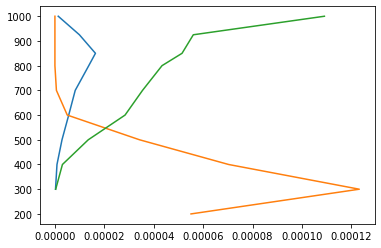

In [33]:
fig, ax = plt.subplots(1, 1)
vnames = (
    'Cloud_Liq_Water_Content',
    'Ice_Water_Content', 
    'Liq_Water_Content', 
)
ds_counts = xr.open_dataset(f_out)
for v in vnames:
    d_sum = ds_counts[v+'_sums']
    d_cnt = ds_counts[v+'_counts']
    
    # Sum over tropics
    d_sum = d_sum.where(d_sum.lat > -30).where(d_sum.lat < 30).sum(dim=('month', 'lat', 'lon'), keep_attrs=True)
    d_cnt = d_cnt.where(d_cnt.lat > -30).where(d_cnt.lat < 30).sum(dim=('month', 'lat', 'lon'), keep_attrs=True)
    #d_sum = np.nansum(d_sum, axis=(0,1,2))#d_sum.sum(dim=('month', 'lat', 'lon'))
    #d_cnt = np.nansum(d_cnt, axis=(0,1,2))#d_cnt.sum(dim=('month', 'lat', 'lon'))

    # Compute mean
    d = 1.0 * d_sum / d_cnt

    # Plot profile
    pl = ax.plot(d, d.plev)

<ipython-input-22-46dbcba89fea>:19: RuntimeWarning: invalid value encountered in true_divide
  d = np.where(d_cnt > 0, d_sum / d_cnt, np.nan)
<ipython-input-22-46dbcba89fea>:19: RuntimeWarning: invalid value encountered in true_divide
  d = np.where(d_cnt > 0, d_sum / d_cnt, np.nan)


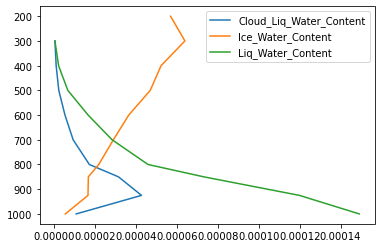

In [22]:
fig, ax = plt.subplots(1, 1)
vnames = (
    'Cloud_Liq_Water_Content',
    'Ice_Water_Content', 
    'Liq_Water_Content', 
)
ds_counts = xr.open_dataset(f_out)
for v in vnames:
    d_sum = monthly_sums[v]
    d_cnt = monthly_cnts[v]
    
    # Sum over tropics
    #d_sum = d_sum.where(d_sum.lat > -30).where(d_sum.lat < 30).sum(dim=('month', 'lat', 'lon'), keep_attrs=True)
    #d_cnt = d_cnt.where(d_cnt.lat > -30).where(d_cnt.lat < 30).sum(dim=('month', 'lat', 'lon'), keep_attrs=True)
    d_sum = np.nansum(d_sum, axis=(0, 1, 2))
    d_cnt = np.nansum(d_cnt, axis=(0, 1, 2))

    # Compute mean
    d = np.where(d_cnt > 0, d_sum / d_cnt, np.nan)
    
    # Plot profile
    pl = ax.plot(d, pgrd, label=v)
    
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend()

In [47]:
for v in monthly_sums.keys():
    print(v, monthly_sums[v].max())

Cloud_Liq_Water_Content 0
Cloud_Liq_Water_Path 127
Ice_Water_Content 0
Ice_Water_Path 127
Liq_Water_Content 0
Liq_Water_Path 127


In [117]:
ds = open_dataset_hdf(files[products[1]][0], variables=('Pressure',))

In [120]:
print(ds.Pressure.max().values)

103863.15
